## Includes

In [1]:
import casadi as ca
import numpy as np
from acados_template import AcadosModel, AcadosOcp, AcadosOcpSolver

## Parameters

In [2]:
# Dynamics parameters

# CRAZYFLIE PARAMETERS
# m = 33e-3                                   # [kg] total mass
# g = 9.8066                                  # [m/s^2] Gravity   
# jx, jy, jz = 1.395e-5, 1.395e-5, 2.173e-5   # [kg.m^2] Inertia moment
# cd  = 7.9379e-06                               # Rotor drag coef
# dx = [0.0325, 0.0325, 0.0325, 0.0325]       # [m] Distance from center to rotors
# dy = [0.0325, 0.0325, 0.0325, 0.0325]       # [m] Distance from center to rotors
# thrust_to_weight = 10.0
# max_force_per_motor = (g * m / 4.0) * thrust_to_weight
# x_0 = np.array([1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# u_min = np.array([0.0, 0.0, 0.0, 0.0])
# u_max = np.array([max_force_per_motor, max_force_per_motor, max_force_per_motor, max_force_per_motor])
# u_hov = np.array([m*g/4.0, m*g/4.0, m*g/4.0, m*g/4.0])

# X500 PARAMETERS
m = 2.0                                     # [kg] total mass
g = 9.8066                                  # [m/s^2] Gravity   
jx, jy, jz = 0.02166, 0.02166, 0.04   # [kg.m^2] Inertia moment
cd  = 8.06428e-05                               # Rotor drag coef
dx = [0.174, 0.174, 0.174, 0.174]       # [m] Distance from center to rotors
dy = [0.174, 0.174, 0.174, 0.174]       # [m] Distance from center to rotors
thrust_to_weight = 1.75
max_force_per_motor = (g * m / 4.0) * thrust_to_weight
x_0 = np.array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
u_min = np.array([0.0, 0.0, 0.0, 0.0])
u_max = np.array([max_force_per_motor, max_force_per_motor, max_force_per_motor, max_force_per_motor])
u_hov = np.array([m*g/4.0, m*g/4.0, m*g/4.0, m*g/4.0])

# Solver parameters
Tf = 1.0
N = 100

## Model Definition

In [9]:
# State variables
px, py, pz = ca.MX.sym('px', 1), ca.MX.sym('py', 1), ca.MX.sym('pz', 1)
vx, vy, vz = ca.MX.sym('vx', 1), ca.MX.sym('vy', 1), ca.MX.sym('vz', 1)
qw, qx, qy, qz = ca.MX.sym('qw',1), ca.MX.sym('qx',1), ca.MX.sym('qy',1), ca.MX.sym('qz',1), 
wx, wy, wz = ca.MX.sym('wx', 1), ca.MX.sym('wy', 1), ca.MX.sym('wz', 1)

# Time derivative of state variables
dpx, dpy, dpz = ca.MX.sym('dpx', 1), ca.MX.sym('dpy', 1), ca.MX.sym('dpz', 1)
dvx, dvy, dvz = ca.MX.sym('dvx', 1), ca.MX.sym('dvy', 1), ca.MX.sym('dvz', 1)
dqw, dqx, dqy, dqz = ca.MX.sym('dqw',1), ca.MX.sym('dqx',1), ca.MX.sym('dqy',1), ca.MX.sym('dqz',1), 
dwx, dwy, dwz = ca.MX.sym('dwx', 1), ca.MX.sym('dwy', 1), ca.MX.sym('dwz', 1)

# Control variables
u0 = ca.MX.sym('u0')
u1 = ca.MX.sym('u1')
u2 = ca.MX.sym('u2')
u3 = ca.MX.sym('u3')

# Stacked state and control variables
x = ca.vertcat(px, py, pz, qw, qx, qy, qz, vx, vy, vz, wx, wy, wz)
xdot = ca.vertcat(dpx, dpy, dpz, dqw, dqx, dqy, dqz, dvx, dvy, dvz, dwx, dwy, dwz)
u = ca.vertcat(u0, u1, u2, u3)

# Model equations
dpx = vx
dpy = vy
dpz = vz
dqw = 0.5 * (-wx*qx - wy*qy - wz*qz)
dqx = 0.5 * ( wx*qw + wz*qy - wy*qz)
dqy = 0.5 * ( wy*qw - wz*qx + wx*qz)
dqw = 0.5 * ( wz*qw + wy*qx - wx*qy)
dvx = (2 * (u0+u1+u2+u3) / m) * (qy*qw + qz*qx)
dvy = (2 * (u0+u1+u2+u3) / m) * (qy*qz - qw*qx)
dvz = ((u0+u1+u2+u3) / m) * (qw*qw - qx*qx - qy*qy +qz*qz) - g
dwx = (1/jx) * (-dx[0]*u0 - dx[1]*u1 + dx[2]*u2 + dx[3]*u3 - wy*jz*wz + wz*jy*wy)
dwy = (1/jy) * ( dy[0]*u0 - dy[1]*u1 - dy[2]*u2 + dy[3]*u3 - wz*jx*wx + wx*jz*wz)
dwz = (1/jz) * (   -cd*u0 +    cd*u1 -    cd*u2 +    cd*u3 - wx*jy*wy + wy*jx*wx)

f_expl = ca.vertcat(dpx, dpy, dpz, dqw, dqx, dqy, dqw, dvx, dvy, dvz, dwx, dwy, dwz)
f_impl = xdot - f_expl

# Model definitions
model = AcadosModel()
model.f_expl_expr = f_expl
model.f_impl_expr = f_impl
model.x = x
model.xdot = xdot
model.u = u
model.name = "nmpc_flight_mode"

## Cost Function

In [10]:
ocp = AcadosOcp()

nx = model.x.size()[0]
nu = model.u.size()[0]
ny = nx + nu
ny_e = nx

W = np.diag([100, 100, 100,
            1e-2, 1e-2, 1e-2, 1e-2,
            1e-5, 1e-5, 1e-5,
            1e-5, 1e-5, 1e-5,
            1e-2, 1e-2, 1e-2, 1e-2])

Vx = np.zeros((ny, nx))
Vx[:nx, :nx] = np.eye(nx)

Vu = np.zeros((ny, nu))
Vu[-nu:, -nu:] = np.eye(nu)

ocp.dims.N   = N
# ocp.cost.cost_type = 'LINEAR_LS'
ocp.cost.W = W
ocp.cost.Vx = Vx
ocp.cost.Vu = Vu
ocp.cost.W_e = W[:nx, :nx]
ocp.cost.Vx_e = Vx[:nx, :nx]
ocp.cost.yref = np.concatenate((x_0, u_hov))
ocp.cost.yref_e = x_0

## Constraints

In [11]:
ocp.constraints.lbu = u_min
ocp.constraints.ubu = u_max
ocp.constraints.x0  = x_0
ocp.constraints.idxbu = np.array([0, 1, 2, 3])

## Solver parameters

In [12]:
#ocp.solver_options.qp_solver = 'FULL_CONDENSING_QPOASES'
# ocp.solver_options.qp_solver = "FULL_CONDENSING_HPIPM"
ocp.solver_options.qp_solver = 'PARTIAL_CONDENSING_HPIPM'
ocp.solver_options.hessian_approx = 'GAUSS_NEWTON'
ocp.solver_options.integrator_type = 'ERK'
ocp.solver_options.nlp_solver_type = 'SQP_RTI'
#ocp.solver_options.nlp_solver_type = 'SQP'

ocp.solver_options.print_level = 0     # Do not print out

ocp.solver_options.tf = Tf
ocp.solver_options.N_horizon = N

ocp.model = model

acados_solver = AcadosOcpSolver(ocp, json_file = 'acados_ocp.json')

rm -f libacados_ocp_solver_nmpc_flight_mode.so
rm -f acados_solver_nmpc_flight_mode.o
cc -fPIC -std=c99   -O2 -I/home/kousheek/Dev/saxion/acados/include -I/home/kousheek/Dev/saxion/acados/include/acados -I/home/kousheek/Dev/saxion/acados/include/blasfeo/include -I/home/kousheek/Dev/saxion/acados/include/hpipm/include  -c -o acados_solver_nmpc_flight_mode.o acados_solver_nmpc_flight_mode.c
cc -fPIC -std=c99   -O2 -I/home/kousheek/Dev/saxion/acados/include -I/home/kousheek/Dev/saxion/acados/include/acados -I/home/kousheek/Dev/saxion/acados/include/blasfeo/include -I/home/kousheek/Dev/saxion/acados/include/hpipm/include  -c -o nmpc_flight_mode_model/nmpc_flight_mode_expl_ode_fun.o nmpc_flight_mode_model/nmpc_flight_mode_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/kousheek/Dev/saxion/acados/include -I/home/kousheek/Dev/saxion/acados/include/acados -I/home/kousheek/Dev/saxion/acados/include/blasfeo/include -I/home/kousheek/Dev/saxion/acados/include/hpipm/include  -c -o nmpc_flight_mode_m

179.27440588134723


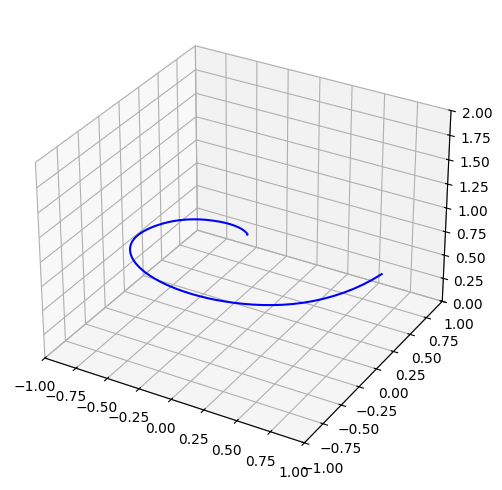

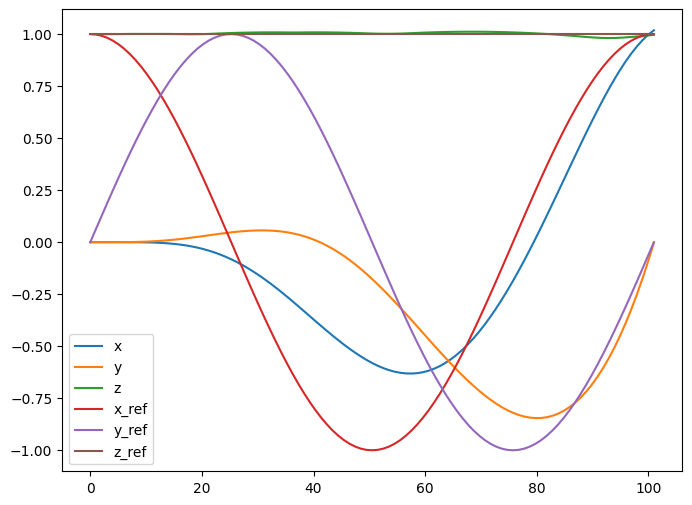

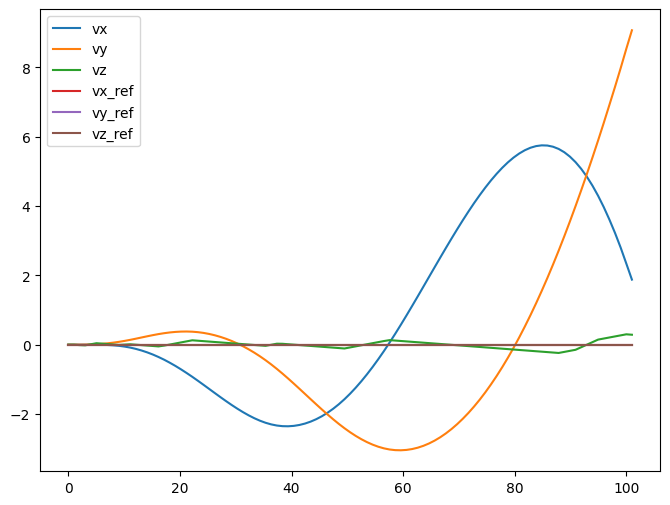

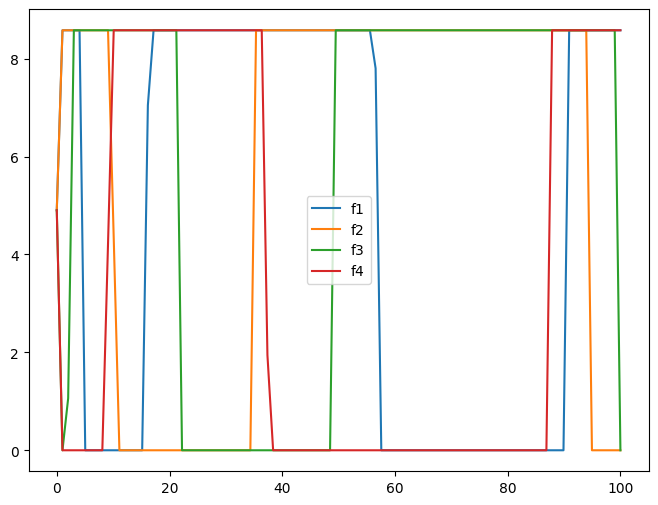

In [14]:
import time

init_time = time.time()
current_state = np.array([0.0, 0.0, 1.0, 
                          1.0, 0.0, 0.0, 0.0, 
                          0.0, 0.0, 0.0,
                          0.0, 0.0, 0.0,])

theta = np.linspace(0, 2.0*np.pi, ocp.dims.N+1)
reference_trajectory = []
for t in theta:
    reference_trajectory.append([np.cos(t), np.sin(t), 1.0, 
                                 1.0, 0.0, 0.0, 0.0, 
                                 0.0, 0.0, 0.0,
                                 0.0, 0.0, 0.0,
                                 max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight])
    
reference_trajectory = np.array(reference_trajectory)

# reference_trajectory = []
# for t in np.linspace(0, 1, ocp.dims.N+1):
#     reference_trajectory.append([t, 0.0, 1.0, 
#                                  1.0, 0.0, 0.0, 0.0, 
#                                  0.0, 0.0, 0.0,
#                                  0.0, 0.0, 0.0,
#                                  max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight])
    
# reference_trajectory = np.array(reference_trajectory)

# Fill initial state
acados_solver.set(0, "lbx", current_state)
acados_solver.set(0, "ubx", current_state)

acados_solver.set(0, 'lbu', np.array([max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight]))
acados_solver.set(0, 'ubu', np.array([max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight, max_force_per_motor/thrust_to_weight]))

for stage in range(ocp.dims.N):
    acados_solver.set(stage, "y_ref", reference_trajectory[stage])

acados_solver.set(ocp.dims.N, "y_ref", reference_trajectory[ocp.dims.N][:nx])
status = acados_solver.solve()

print(1/ (time.time() - init_time))

us = []
xs = []

for i in range(ocp.dims.N+1):
    xs.append(acados_solver.get(i, "x"))

for i in range(ocp.dims.N):
    us.append(acados_solver.get(i, "u"))

us = np.vstack(us)
xs = np.vstack(xs)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D line
ax.plot(xs[:, 0], xs[:, 1], xs[:, 2], label='3D Line', color='b')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(0, 2)
plt.show()

# X Y Z pos vs reference pos
t = np.linspace(0, ocp.dims.N+1, ocp.dims.N+1)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.plot(t, xs[:, 0], label='x')
ax.plot(t, xs[:, 1], label='y')
ax.plot(t, xs[:, 2], label='z')
ax.plot(t, reference_trajectory[:, 0], label='x_ref')
ax.plot(t, reference_trajectory[:, 1], label='y_ref')
ax.plot(t, reference_trajectory[:, 2], label='z_ref')
ax.legend()
plt.show()

# X Y Z vel vs reference vel
t = np.linspace(0, ocp.dims.N+1, ocp.dims.N+1)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.plot(t, xs[:, 7], label='vx')
ax.plot(t, xs[:, 8], label='vy')
ax.plot(t, xs[:, 9], label='vz')
ax.plot(t, reference_trajectory[:, 7], label='vx_ref')
ax.plot(t, reference_trajectory[:, 8], label='vy_ref')
ax.plot(t, reference_trajectory[:, 9], label='vz_ref')
ax.legend()
plt.show()

# Control signals
t = np.linspace(0, ocp.dims.N, ocp.dims.N)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.plot(t, us[:, 0], label='f1')
ax.plot(t, us[:, 1], label='f2')
ax.plot(t, us[:, 2], label='f3')
ax.plot(t, us[:, 3], label='f4')
ax.legend()
plt.show()
